In [1]:
from google.colab import drive

# Step 2: Mount Google Drive
try:
  drive.mount('/content/drive')
  print("✅ Google Drive mounted successfully!")

  print("🎯 Setup complete")

except Exception as e:
    print("❌ Setup failed:", e)

Mounted at /content/drive
✅ Google Drive mounted successfully!
🎯 Setup complete


In [9]:
# ===============================
# 2. Imports
# ===============================
import time
import os
import numpy as np
import pandas as pd
from tabulate import tabulate

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report
from sklearn.preprocessing import LabelEncoder

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (
    Embedding, Conv1D, MaxPooling1D,
    GlobalMaxPooling1D, Dense, Dropout, BatchNormalization
)
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.optimizers import Adam

from sklearn.metrics import (
    classification_report, confusion_matrix, roc_auc_score, f1_score,
    precision_recall_fscore_support, roc_curve, auc
)

In [3]:
# Direct raw CSV link from GitHub
DATA_URL = "https://raw.githubusercontent.com/Nicole0906/DLI_Group_Assignment/main/Phishing_Legitimate_full%203.csv"
LOCAL_FILE = "phishing_dataset.csv"

def load_dataset():
    if not os.path.exists(LOCAL_FILE):
        print("⬇️  Downloading dataset from GitHub …")
        os.system(f"wget -q -O {LOCAL_FILE} {DATA_URL}")
    else:
        print("📂 Using cached local dataset:", LOCAL_FILE)
    print("📦 Loading dataset into DataFrame …")
    return pd.read_csv(LOCAL_FILE), "GitHub"

df, DATA_SRC = load_dataset()
print(f"✅ Dataset loaded from {DATA_SRC}. Shape: {df.shape}")
display(df.head(3))


⬇️  Downloading dataset from GitHub …
📦 Loading dataset into DataFrame …
✅ Dataset loaded from GitHub. Shape: (10000, 50)


,id,NumDots,SubdomainLevel,PathLevel,UrlLength,NumDash,NumDashInHostname,AtSymbol,TildeSymbol,NumUnderscore,...,IframeOrFrame,MissingTitle,ImagesOnlyInForm,SubdomainLevelRT,UrlLengthRT,PctExtResourceUrlsRT,AbnormalExtFormActionR,ExtMetaScriptLinkRT,PctExtNullSelfRedirectHyperlinksRT,CLASS_LABEL
0,1,3,1,5,72,0,0,0,0,0,...,0,0,1,1,0,1,1,-1,1,1
1,2,3,1,3,144,0,0,0,0,2,...,0,0,0,1,-1,1,1,1,1,1
2,3,3,1,2,58,0,0,0,0,0,...,0,0,0,1,0,-1,1,-1,0,1


In [6]:

# ===============================
# 4. Preprocessing
# ===============================
SEED = 42

# Features / Target
X = df.drop(columns=["id", "CLASS_LABEL"])
y = df["CLASS_LABEL"]

unique_labels = sorted(y.unique())
label_map = {0: "Legitimate", 1: "Phishing"}

print("\nFeature shape:", X.shape)
print("Target distribution:\n", y.value_counts())

pos_rate = y.mean()
print(f"\n⚖️ Positive class rate: {pos_rate:.3f}")

IMBALANCED = (pos_rate < 0.35) or (pos_rate > 0.65)
CLASS_WEIGHT = "balanced" if IMBALANCED else None
print(f"Class weighting: {CLASS_WEIGHT if CLASS_WEIGHT else 'None'}")

# Split train/val/test
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.3, random_state=SEED, stratify=y
)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=SEED, stratify=y_temp
)

# Encode labels
le = LabelEncoder()
y_train = le.fit_transform(y_train)
y_val = le.transform(y_val)
y_test = le.transform(y_test)

# ===============================
# 5. Character Mapping
# ===============================
X_texts = X.astype(str).agg(" ".join, axis=1).tolist()
all_text = "".join(X_texts)

char_index = {ch: i + 1 for i, ch in enumerate(sorted(set(all_text)))}
sequence_length = 600
embed_dim = 256  # bigger embedding for richer features

print(f"Vocabulary size: {len(char_index)}")

# Function: convert texts to sequences
def texts_to_sequences(texts, char_index):
    sequences = []
    for text in texts:
        seq = [char_index.get(ch, 0) for ch in text]
        sequences.append(seq)
    return sequences

# Convert each split
X_train_texts = X_train.astype(str).agg(" ".join, axis=1).tolist()
X_val_texts   = X_val.astype(str).agg(" ".join, axis=1).tolist()
X_test_texts  = X_test.astype(str).agg(" ".join, axis=1).tolist()

X_train_seq = texts_to_sequences(X_train_texts, char_index)
X_val_seq   = texts_to_sequences(X_val_texts, char_index)
X_test_seq  = texts_to_sequences(X_test_texts, char_index)

# Pad sequences
X_train_seq = pad_sequences(X_train_seq, maxlen=sequence_length, padding="post")
X_val_seq   = pad_sequences(X_val_seq, maxlen=sequence_length, padding="post")
X_test_seq  = pad_sequences(X_test_seq, maxlen=sequence_length, padding="post")

# ===============================
# 6. CNN Model
# ===============================
def cnn_complex(voc_size, embed_dim, sequence_length):
    model = Sequential()
    model.add(Embedding(voc_size + 1, embed_dim))

    # Block 1
    model.add(Conv1D(128, 3, activation='relu', padding='same'))
    model.add(MaxPooling1D(3))
    model.add(BatchNormalization())
    model.add(Dropout(0.3))

    # Block 2
    model.add(Conv1D(128, 5, activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(Dropout(0.3))

    # Block 3
    model.add(Conv1D(128, 3, activation='relu', padding='same'))
    model.add(MaxPooling1D(3))
    model.add(BatchNormalization())
    model.add(Dropout(0.3))

    # Pooling instead of Flatten
    model.add(GlobalMaxPooling1D())

    # Dense + Output
    model.add(Dense(128, activation='tanh'))
    model.add(Dropout(0.5))
    model.add(Dense(1, activation='sigmoid'))  # binary classification

    return model

# ===============================
# 7. Train Model
# ===============================
voc_size = len(char_index)
model = cnn_complex(voc_size, embed_dim, sequence_length)

model.compile(
    loss="binary_crossentropy",
    optimizer=Adam(learning_rate=1e-3),
    metrics=['accuracy']
)

history = model.fit(
    X_train_seq, y_train,
    validation_data=(X_val_seq, y_val),
    epochs=130,
    batch_size=32,
    class_weight=CLASS_WEIGHT,
    verbose=1
)
y_val_prob = model.predict(X_val_seq, batch_size=32)

from sklearn.metrics import f1_score

best_f1, best_t = 0, 0.5
for t in np.linspace(0.1, 0.9, 81):  # thresholds 0.1 → 0.9
    preds = (y_val_prob > t).astype(int)
    f1 = f1_score(y_val, preds)
    if f1 > best_f1:
        best_f1, best_t = f1, t

print(f"\n🔎 Best threshold from validation: {best_t:.2f}, F1: {best_f1:.4f}")
# ===============================
# 8. Evaluation with tuned threshold
# ===============================
start_time = time.time()
y_test_prob = model.predict(X_test_seq, batch_size=32)
inference_time = (time.time() - start_time) / len(X_test_seq)

# Use best threshold instead of 0.5
y_test_pred = (y_test_prob > best_t).astype(int)

# Metrics
acc  = accuracy_score(y_test, y_test_pred)
prec = precision_score(y_test, y_test_pred, average="binary", zero_division=0)
rec  = recall_score(y_test, y_test_pred, average="binary", zero_division=0)
f1   = f1_score(y_test, y_test_pred, average="binary", zero_division=0)

print(f"\n📊 Test F1 using threshold {best_t:.2f}: {f1:.4f}")


params = model.count_params()

metrics_table = [
    ["Accuracy", acc],
    ["Precision", prec],
    ["Recall", rec],
    ["F1 Score", f1],
    ["Params", params],
    ["Avg Inference (sec/sample)", inference_time]
]

print("\n📊 Overall Metrics:\n")
print(tabulate(metrics_table, headers=["Metric", "Value"], tablefmt="pretty"))

# Per-class report
print("\n📌 Per-class Metrics:\n")
print(classification_report(y_test, y_test_pred, target_names=[label_map[0], label_map[1]]))

# ===============================
# 9. Threshold Sweep on Test Set
# ===============================
from sklearn.metrics import f1_score

best_f1_test, best_t_test = 0, 0.5
for t in np.linspace(0.1, 0.9, 81):  # thresholds 0.1 → 0.9
    preds = (y_test_prob > t).astype(int)
    f1 = f1_score(y_test, preds)
    if f1 > best_f1_test:
        best_f1_test, best_t_test = f1, t

print(f"\n🔎 Best threshold on test: {best_t_test:.2f}, F1: {best_f1_test:.4f}")




Feature shape: (10000, 48)
Target distribution:
 CLASS_LABEL
1    5000
0    5000
Name: count, dtype: int64

⚖️ Positive class rate: 0.500
Class weighting: None
Vocabulary size: 13
Epoch 1/130
219/219 ━━━━━━━━━━━━━━━━━━━━ 17s 39ms/step - accuracy: 0.7424 - loss: 0.5346 - val_accuracy: 0.5000 - val_loss: 0.6971
Epoch 2/130
219/219 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - accuracy: 0.9157 - loss: 0.2401 - val_accuracy: 0.7973 - val_loss: 0.2765
Epoch 3/130
219/219 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - accuracy: 0.9272 - loss: 0.2188 - val_accuracy: 0.9107 - val_loss: 0.2185
Epoch 4/130
219/219 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - accuracy: 0.9405 - loss: 0.1961 - val_accuracy: 0.9533 - val_loss: 0.1294
Epoch 5/130
219/219 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step - accuracy: 0.9386 - loss: 0.1821 - val_accuracy: 0.9607 - val_loss: 0.1193
Epoch 6/130
219/219 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - accuracy: 0.9395 - loss: 0.1783 - val_accuracy: 0.9573 - val_loss: 0.1169
Epoch 7/130
219/219 ━━━━━━━━━━━━━━━━━━

In [7]:
# ===============================
# Save Model
# ===============================
model_path = "/content/drive/MyDrive/Colab Notebooks/DLI assignment/CNN_Best.keras"
model.save(model_path)
print(f"\n✅ Model saved at: {model_path}")




✅ Model saved at: /content/drive/MyDrive/Colab Notebooks/DLI assignment/CNN_Best.keras


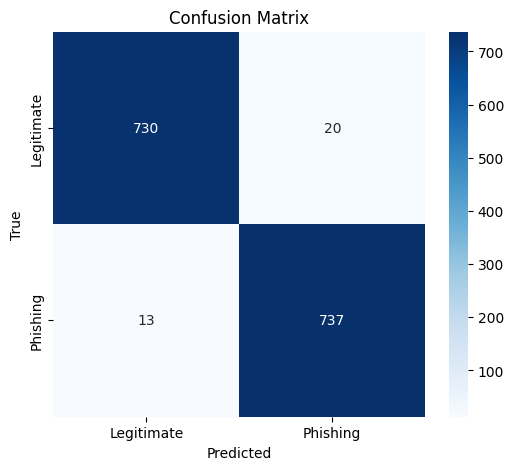

In [11]:
# ===============================
# 10. Confusion Matrix
# ===============================
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test, y_test_pred)

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=[label_map[0], label_map[1]],
            yticklabels=[label_map[0], label_map[1]])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()
